In [32]:
!pip install -r ../requirements.txt --no-dependencies

^C


In [3]:
import tensorflow as tf
import apache_beam as beam
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from apache_beam import dataframe
from apache_beam.ml.inference.base import RunInference
from apache_beam.runners.interactive.interactive_runner import InteractiveRunner
from tensorflow import keras
from tensorflow.keras import layers

import apache_beam.runners.interactive.interactive_beam as ib

### wip: GCP runner

In [4]:
project = "<PROJECT_ID>"
bucket = "<BUCKET_NAME>"

save_model_dir_multiply = f'gs://{bucket}/tfx-inference/model/multiply_five/v1/'

### Model training
##### Load data

In [5]:
data = pd.read_csv('../anomaly_detection/dtc_opportunity.csv')

##### Create feature
Create opportunity duration column days defined as

In [6]:
data['Created Date'] = pd.to_datetime(data['Created Date'], format='%Y-%m-%dT%H:%M:%S.%f').dt.tz_localize(None)
data['Close Date'] = pd.to_datetime(data['Close Date'], format='%m/%d/%y').dt.tz_localize(None)
data['Opportunity Duration Days'] = data['Close Date'] - data['Created Date']
data['Opportunity Duration Days'] = data['Opportunity Duration Days'].dt.days

##### Drop nans

In [7]:
data.isna().sum()

Opportunity Name               0
Billing State/Province       392
Account Type                   0
Account Owner                  0
Product Name                  97
Amount                         0
#                              0
Account Name                   0
Billing Country                0
Close Date                     0
Closed                         0
Created Date                   0
Forecast Category              0
Industry                       0
Opportunity Owner              0
Opportunity Source             0
Opportunity Type               0
Owner Role                     0
Product Family                97
Segment                        0
Stage                          0
Won                            0
Opportunity Duration Days      0
dtype: int64

In [8]:
data = data.dropna()

##### Save intermediate csv
Is used in data processing pipeline

In [9]:
data.to_csv('tensorflow_regression_opportunity.csv', index=False)

In [10]:
def get_one_hot_encoding(df, col) -> pd.DataFrame:
    beam_df_categorical = df[col]
    with dataframe.allow_non_parallel_operations():
        unique_classes = pd.CategoricalDtype(ib.collect(beam_df_categorical.unique(as_series=True)))
    beam_df_categorical = beam_df_categorical.astype(unique_classes).str.get_dummies()
    beam_df_categorical = beam_df_categorical.add_prefix(f'{col}___')

    return beam_df_categorical

In [11]:
TARGET_COLUMN = {'Opportunity_Duration_Days'}

##### Train data preprocessing pipeline
splits the data to train/test set, encodes the data for model input

In [12]:
with beam.Pipeline(InteractiveRunner()) as p:
    input_data = p | "Read CSV" >> beam.dataframe.io.read_csv('tensorflow_regression_opportunity.csv')
    # For now dropping dates
    input_data = input_data.drop(['Billing State/Province',
                                  'Created Date',
                                  'Close Date',
                                  'Account Name',
                                  'Product Name',
                                  'Opportunity Name'], axis=1)
    input_data = input_data.drop('#', axis=1)
    input_data = input_data.replace('-', 'HYPHEN', regex=True)
    input_data = input_data.replace('/', 'SLASH', regex=True)
    input_data = input_data.replace(' ', 'SPACE', regex=True)
    input_data = input_data.rename(columns={x: x.replace(' ', '_') for x in input_data.columns})

    with dataframe.allow_non_parallel_operations():
        input_data = input_data.dropna()

    numerical_cols = set(input_data.select_dtypes(include=np.number).columns.tolist()) - TARGET_COLUMN
    bool_cols = input_data.select_dtypes(include='bool').columns.tolist()
    categorical_cols = list(set(input_data.columns) - set(numerical_cols) - set(bool_cols) - TARGET_COLUMN)
    input_data_numericals = input_data.filter(items=numerical_cols)
    input_data_numericals = (input_data_numericals - input_data_numericals.mean())/input_data_numericals.std()

    processed_cat_columns = []

    for categorical_col in categorical_cols:
        input_data_categorical = get_one_hot_encoding(df=input_data, col=categorical_col)
        processed_cat_columns.extend(list(input_data_categorical.columns))
        input_data_numericals = input_data_numericals.merge(input_data_categorical, left_index=True, right_index=True)

    for bool_col in bool_cols:
        input_data_numericals = input_data_numericals.merge(input_data[bool_col].astype(int), left_index=True, right_index=True)

    input_data_numericals = input_data_numericals.merge(input_data[list(TARGET_COLUMN)].astype(int), left_index=True, right_index=True)

aa = ib.collect(input_data_numericals)
train = aa.sample(frac=0.8, random_state=42)
test = aa.drop(train.index)
train.to_csv('tensorflow_output_train_final.csv', index=False)
test.to_csv('tensorflow_output_test_final.csv', index=False)

C:\Users\Marko\Desktop\Projects\DnA_accelerators\python-runinference\venv\lib\site-packages\apache_beam\dataframe\frame_base.py:145: RuntimeWarning: invalid value encountered in longlong_scalars
  lambda left, right: getattr(left, op)(right), name=op, args=[other])


##### Load train/test data
From pipeline output

In [13]:
train_df = pd.read_csv("tensorflow_output_train_final.csv")
test_df = pd.read_csv("tensorflow_output_test_final.csv")

In [14]:
train_features = train_df.copy()
test_features = test_df.copy()

train_labels = train_features.pop(list(TARGET_COLUMN)[0])
test_labels = test_features.pop(list(TARGET_COLUMN)[0])

In [15]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

##### Define keras model

In [16]:
def build_and_compile_model(shape):
  model = keras.Sequential([
      layers.Input(shape=(shape,), name='x'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

##### Features to tfrecord dataset of examples

In [17]:
class ExampleProcessor:
    def create_example_with_label(self, feature: np.float32,
                                  label: np.float32)-> tf.train.Example:
        return tf.train.Example(
            features=tf.train.Features(
                feature={'x': self.create_feature(feature),
                         'y' : self.create_y(label)
                         }))

    def create_example(self, feature: np.float32):
        return tf.train.Example(
            features=tf.train.Features(
                feature={'x' : self.create_feature(feature)})
        )

    def create_feature(self, element):
        return tf.train.Feature(float_list=tf.train.FloatList(value=element))

    def create_y(self, element):
        return tf.train.Feature(float_list=tf.train.FloatList(value=[element]))


train_tfrec = 'train_op.tfrecord'

with tf.io.TFRecordWriter(train_tfrec) as writer:
    for train_d, test_d in zip(train_features.to_numpy(), train_labels.to_numpy()):
        example = ExampleProcessor().create_example_with_label(
            feature=train_d, label=test_d)
        writer.write(example.SerializeToString())


test_tfrec = 'test_op.tfrecord'

with tf.io.TFRecordWriter(test_tfrec) as writer:
    for train_d, test_d in zip(test_features.to_numpy(), test_labels.to_numpy()):
        example = ExampleProcessor().create_example_with_label(
            feature=train_d, label=test_d)
        writer.write(example.SerializeToString())

In [18]:
RAW_DATA_TRAIN_SPEC = {
    'x': tf.io.FixedLenSequenceFeature([], tf.float32, allow_missing=True),
    'y': tf.io.FixedLenSequenceFeature([], tf.float32, allow_missing=True)
}

train_dataset = tf.data.TFRecordDataset(train_tfrec)
train_dataset = train_dataset.map(lambda e : tf.io.parse_example(e, RAW_DATA_TRAIN_SPEC))
train_dataset = train_dataset.map(lambda t : (t['x'], t['y']))
train_dataset = train_dataset.batch(1)
train_dataset = train_dataset.repeat()

test_dataset = tf.data.TFRecordDataset(train_tfrec)
test_dataset = test_dataset.map(lambda e : tf.io.parse_example(e, RAW_DATA_TRAIN_SPEC))
test_dataset = test_dataset.map(lambda t : (t['x'], t['y']))
test_dataset = test_dataset.batch(1)


dnn_model = build_and_compile_model(shape=train_features.shape[1])
dnn_model.build()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [19]:
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                7168      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 11,393
Trainable params: 11,393
Non-trainable params: 0
_________________________________________________________________


##### Fit the model
Starts the training

In [20]:
history = dnn_model.fit(
    train_dataset,
    validation_data=test_dataset,
    steps_per_epoch=8,
    verbose=0, epochs=100)

##### Plot loss graph

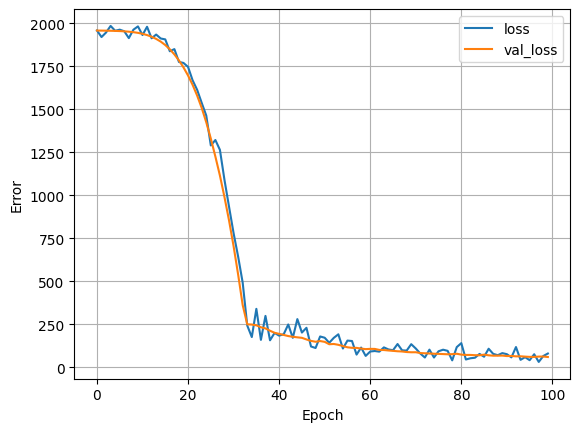

In [21]:
plot_loss(history)

##### Collect the final results on the test set
Mean Squared Error

In [22]:
dnn_model.evaluate(test_features, test_labels, verbose=0)

90.03837585449219

##### Save the trained model

In [25]:
from tfx_bsl.public.beam.run_inference import CreateModelHandler
from tfx_bsl.public.proto import model_spec_pb2

In [26]:
RAW_DATA_PREDICT_SPEC = {
    'x': tf.io.FixedLenSequenceFeature([], tf.float32, allow_missing=True),
}


@tf.function(input_signature=[tf.TensorSpec(shape=[None], dtype=tf.string)])
def serve_tf_examples_fn(data):
    print(data.shape)
    features = tf.io.parse_example(data, RAW_DATA_PREDICT_SPEC)
    """Returns the output to be used in the serving signature."""
    return dnn_model(features, training=False)

signature = {'serving_default': serve_tf_examples_fn}

In [27]:
tf.keras.models.save_model(dnn_model, 'pretrained/tf_regressor', signatures=signature)

(None,)


INFO:tensorflow:Assets written to: pretrained/tf_regressor\assets


INFO:tensorflow:Assets written to: pretrained/tf_regressor\assets


##### Output format function

In [30]:
class FormatOutput(beam.DoFn):
    def process(self, element):
        predict_log = element.predict_log
        input_value = tf.train.Example.FromString(predict_log.request.inputs['data'].string_val[0])
        input_float_value = input_value.features.feature['x'].float_list.value[0]
        output_value = predict_log.response.outputs
        output_float_value = output_value['output_0'].float_val[0]
        yield f"example is {input_float_value:.2f} prediction is {output_float_value:.2f}"

### Inference pipeline

In [31]:
saved_model_spec = model_spec_pb2.SavedModelSpec(model_path='pretrained/tf_regressor')
inference_spec_type = model_spec_pb2.InferenceSpecType(saved_model_spec=saved_model_spec)
model_handler = CreateModelHandler(inference_spec_type)


with beam.Pipeline(InteractiveRunner()) as p:
    data = (p | "Read CSV" >> beam.dataframe.io.read_csv("tensorflow_output_test_final.csv"))
    data = beam.dataframe.convert.to_pcollection(data)
    result = (
         data
         | beam.Map(lambda dx: [x for x in dx[:-1]])
         | "Convert to tf.Examples" >> beam.Map(lambda x: ExampleProcessor().create_example(feature=x).SerializeToString())
         | RunInference(model_handler)
         | beam.ParDo(FormatOutput())
         | beam.Map(print)
         )


INFO:tensorflow:Restoring parameters from pretrained/tf_regressor\variables\variables


INFO:tensorflow:Restoring parameters from pretrained/tf_regressor\variables\variables


example is -0.86 prediction is 2065.53
example is -0.66 prediction is 1941.88
example is 1.41 prediction is 1890.25
example is -0.94 prediction is 1970.32
example is 0.39 prediction is 1967.84
example is 1.54 prediction is 1994.37
example is 0.08 prediction is 1930.10
example is -0.82 prediction is 2033.45
example is 0.71 prediction is 1883.18
example is -0.91 prediction is 1993.47
example is -0.04 prediction is 1722.71
example is -0.94 prediction is 1983.44
example is 0.13 prediction is 1825.49
example is -0.35 prediction is 1943.51
example is 0.64 prediction is 1870.51
example is -0.06 prediction is 1905.43
example is -0.51 prediction is 2064.30
example is -0.27 prediction is 1858.67
example is -0.77 prediction is 1849.76
example is 1.93 prediction is 1816.56
example is 0.69 prediction is 1901.47
example is 0.39 prediction is 1829.45
example is 0.84 prediction is 1917.71
example is 0.39 prediction is 2034.84
example is -0.88 prediction is 2029.16
example is 0.63 prediction is 1860.60